# Begin visualisations

In [13]:
from pathlib import Path
import pandas as pd
import sqlite3
import networkx as nx
#import matplotlib.pyplot as plt
from ipycytoscape import CytoscapeWidget
from sqlite3 import OperationalError
from contextlib import suppress
import ipywidgets as widgets
from pprint import pprint
import py4cytoscape as p4c

In [14]:
working = Path('..')
working

PosixPath('..')

In [15]:
!pwd

/Users/Jon/Developer/Github/dh-trace/notebooks


In [16]:
!ls $working

LICENSE                   hapaxes_1tM.py            make_histogram.py
Project History.pdf       init_db.py                make_jumbo_dash.py
README.md                 load_alignments.py        make_lines.py
__pycache__               load_authors_and_texts.py notebooks
arch                      load_hapax_intersects.py  poetry.lock
authors.txt               load_hapaxes.py           predict_ops.py
auto_author_prediction.py load_jaccard.py           projects
begin.sh                  load_ngram_intersects.py  pyproject.toml
database_ops.py           load_ngrams.py            requirements.txt
dh-trace-venv             load_relationships.py     show_previous_averages.py
diagrams.ipynb            make_3d_plot.py           util.py
do_svm.py                 make_auto_scatterplot.py  utils
do_viz.sh                 make_confusion.py
explore                   make_dash.py


In [17]:
things = working.glob('*')

In [18]:
for thing in things:
    print(thing)

../make_dash.py
../database_ops.py
../diagrams.ipynb
../.DS_Store
../LICENSE
../requirements.txt
../make_lines.py
../util.py
../auto_author_prediction.py
../make_confusion.py
../projects
../pyproject.toml
../predict_ops.py
../load_jaccard.py
../do_viz.sh
../utils
../__pycache__
../load_hapaxes.py
../Project History.pdf
../explore
../README.md
../load_ngram_intersects.py
../load_hapax_intersects.py
../load_ngrams.py
../.gitignore
../arch
../.venv
../load_alignments.py
../make_jumbo_dash.py
../begin.sh
../load_authors_and_texts.py
../hapaxes_1tM.py
../make_auto_scatterplot.py
../show_previous_averages.py
../make_3d_plot.py
../poetry.lock
../.git
../.vscode
../load_relationships.py
../authors.txt
../dh-trace-venv
../make_histogram.py
../notebooks
../do_svm.py
../.current_project
../init_db.py


In [19]:
project_name = 'sm-test'
project_path = working / 'projects' / project_name

In [20]:
project_path

PosixPath('../projects/sm-test')

In [21]:
db_path = project_path / 'db' / f'{project_name}.db'
db_path

PosixPath('../projects/sm-test/db/sm-test.db')

In [22]:
db_path.exists()

True

In [23]:
# Define the EDGES_QUERY template with placeholders for weight_id and threshold
EDGES_QUERY_TEMPLATE = """
WITH RankedResults AS (
    SELECT 
        calculation.pair_id,
        round(calculation.comp_score, 3) as comp_score,
        calculation.threshold,
        weight.weight_id,
        weight.hap_weight,
        weight.al_weight,
        weight.svm_weight,
        text_pair.text_a AS a_text_id,
        text_pair.text_b AS b_text_id,
        text_a.source_filename AS a_text_filename,
        text_b.source_filename AS b_text_filename,
        dir_a.id AS a_work_dir_id,
        dir_b.id AS b_work_dir_id,
        dir_a.dir AS a_work,
        dir_b.dir AS b_work,
        text_a.author_id AS a_author_id,
        text_b.author_id AS b_author_id,
        calculation.same_author,
        author_a.author_name AS a_author,
        author_b.author_name AS b_author,
        ROW_NUMBER() OVER (PARTITION BY weight.weight_id, calculation.threshold ORDER BY calculation.pair_id) as row_num
    FROM calculations AS calculation
        JOIN text_pairs AS text_pair ON text_pair.id = calculation.pair_id
        JOIN weights AS weight ON weight.weight_id = calculation.weight_id
        JOIN all_texts AS text_a ON text_a.text_id = text_pair.text_a
        JOIN all_texts AS text_b ON text_b.text_id = text_pair.text_b
        JOIN dirs AS dir_a ON dir_a.id = text_a.dir
        JOIN dirs AS dir_b ON dir_b.id = text_b.dir
        JOIN authors AS author_a ON author_a.id = text_a.author_id
        JOIN authors AS author_b ON author_b.id = text_b.author_id
    WHERE weight.weight_id = {weight_id}
    AND calculation.threshold = {threshold}
    AND dir_a.id <> dir_b.id
    LIMIT 100
)
SELECT *
FROM RankedResults
ORDER BY weight_id, pair_id
"""
#add LIMIT 100 at bottom to limit results to first 100

In [24]:
EDGES_QUERY_TEMPLATE

'\nWITH RankedResults AS (\n    SELECT \n        calculation.pair_id,\n        round(calculation.comp_score, 3) as comp_score,\n        calculation.threshold,\n        weight.weight_id,\n        weight.hap_weight,\n        weight.al_weight,\n        weight.svm_weight,\n        text_pair.text_a AS a_text_id,\n        text_pair.text_b AS b_text_id,\n        text_a.source_filename AS a_text_filename,\n        text_b.source_filename AS b_text_filename,\n        dir_a.id AS a_work_dir_id,\n        dir_b.id AS b_work_dir_id,\n        dir_a.dir AS a_work,\n        dir_b.dir AS b_work,\n        text_a.author_id AS a_author_id,\n        text_b.author_id AS b_author_id,\n        calculation.same_author,\n        author_a.author_name AS a_author,\n        author_b.author_name AS b_author,\n        ROW_NUMBER() OVER (PARTITION BY weight.weight_id, calculation.threshold ORDER BY calculation.pair_id) as row_num\n    FROM calculations AS calculation\n        JOIN text_pairs AS text_pair ON text_pair.

In [25]:
con = sqlite3.connect(db_path)

In [26]:
#creates a view of the extensive query above and lets me work with it as if it's a tables

# Fetch unique weight_ids from the database
weight_ids_query = "SELECT DISTINCT weight_id FROM weights"
weight_ids_df = pd.read_sql(weight_ids_query, con)
weight_ids = weight_ids_df['weight_id'].tolist()

# Fetch unique thresholds from the database
thresholds_query = "SELECT DISTINCT threshold FROM calculations"
thresholds_df = pd.read_sql(thresholds_query, con)
thresholds = thresholds_df['threshold'].tolist()

i = 0
con.execute("DROP TABLE IF EXISTS edges")
con.execute("BEGIN TRANSACTION")
for weight_id in weight_ids:
    for threshold in thresholds:
        # Format the query with the current weight_id and threshold
        formatted_query = EDGES_QUERY_TEMPLATE.format(weight_id=weight_id, threshold=threshold)
        
        if i < 1:
            # Create the initial view
            create_view_query = f"CREATE TEMP TABLE edges AS {formatted_query}"
            with suppress(sqlite3.OperationalError):
                con.execute(create_view_query)
            i += 1
        else:
            append_view_query = f"INSERT INTO edges SELECT * FROM ({formatted_query})"
            con.execute(append_view_query)
            #TODO - check suppression of errors

con.commit()

In [30]:
all_results = []
for weight_id in weight_ids:
    for threshold in thresholds:
        # Format the query with the current weight_id and threshold
        query = EDGES_QUERY_TEMPLATE.format(weight_id=weight_id, threshold=threshold)
        
        # Execute the query and fetch results
        results = pd.read_sql(query, con)
        
        # Add results to the list
        all_results.append(results)

# Combine all results into a single DataFrame
edges_df = pd.concat(all_results, ignore_index=True)

In [31]:
#edges_df = pd.read_sql(df_query, con)
print(f"{len(edges_df):,}")
print(edges_df.sample(n=100, random_state=42))

21,600
       pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
17802      111       0.759       0.70         22       0.350      0.325   
10249     1740       0.786       0.90         12       0.250      0.500   
10385     2808       0.816       0.95         12       0.250      0.500   
6407       878       0.579       0.60          8       0.200      0.200   
15364     2403       0.708       0.65         19       0.300      0.300   
...        ...         ...        ...        ...         ...        ...   
11354     2082       0.805       0.65         14       0.500      0.250   
8913       983       0.809       0.65         11       0.550      0.225   
7870      2570       0.611       0.90          9       0.225      0.225   
8300        54       0.834       0.75         10       0.225      0.550   
2119      1201       0.866       0.85          2       0.700      0.150   

       svm_weight  a_text_id  b_text_id                    a_text_filename  \
17802       0.

In [32]:
# SOLVED A way to choose whether to exclude a piece of a work from connecting to itself (e.g. Trollope 1840 ch 10, ibid ch 20) (solved in SQL)

#A way to visibly toggle the thresholds to fine-grainedly shade edges and possibly connect them closer

#A way to only display desired authors all the way down to one
#A way to visibly toggle the weights
#A way to light up nodes above a certain threshold even if lower thresholds are displayed
#use pandas to group by work so individual book can be displayed on the graph below. 

edges_df = edges_df.sample(1000)
print(len(edges_df))
min_comp_score = edges_df['comp_score'].min() 
max_comp_score = edges_df['comp_score'].max() 
print(min_comp_score, max_comp_score)

1000
0.439 0.921


In [33]:
G = nx.from_pandas_edgelist(
    edges_df,
    source = 'a_text_filename',
    target = 'b_text_filename',
    edge_attr = ['comp_score'],
    create_using = nx.DiGraph)
                            
                            

In [34]:
print(edges_df.sample(n=10))

       pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
5539      1601       0.846       0.95          6       0.600      0.200   
635       1557       0.590       0.90          0       0.150      0.150   
988       2939       0.870       0.65          1       0.150      0.700   
17588     2939       0.702       0.95         21       0.325      0.325   
6542      1651       0.705       0.65          8       0.200      0.200   
14506      855       0.838       0.65         18       0.300      0.400   
9484      2807       0.836       0.90         11       0.550      0.225   
17378     2721       0.743       0.85         21       0.325      0.325   
14686     2813       0.774       0.70         18       0.300      0.400   
16230     1521       0.804       0.70         20       0.400      0.300   

       svm_weight  a_text_id  b_text_id                    a_text_filename  \
5539        0.200        593        236  1840-ENG18400—Trollope-chapter_11   
635         0.700 

In [35]:
G

In [36]:
TEXT_FONT_SIZE = 8

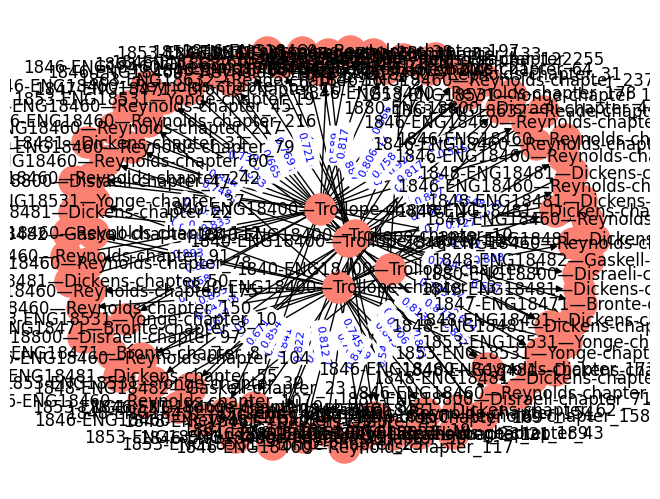

In [37]:
# Position nodes using Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(G)

 # Draw nodes with labels
nx.draw(G, width=1, node_size=500, node_color='salmon', with_labels=True)
# Draw edges with arrows and labels
edge_labels = nx.get_edge_attributes(G, 'comp_score')
_ = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=TEXT_FONT_SIZE)


In [38]:
C = CytoscapeWidget()
#C.set_layout(name='cola')
C.set_layout(name='dagre', rankDir='LR', spacingFactor=3)
C.graph.add_graph_from_networkx(G, directed=True)


In [40]:
#this is so we can programmatically edit and choose variables for the graph

def build_style(color_threshold):
    return [
        {
             'selector': 'node',
             'style': {
                 'background-color': 'salmon',
                 'font-family': 'helvetica',
                 'font-size': f"{TEXT_FONT_SIZE}px",
                 'label': 'data(id)'
             }
        },
        {
             'selector': 'edge',
             'style': {
                 'line-color': 'black',
                 'font-family': 'helvetica',
                 'font-size': f"{TEXT_FONT_SIZE}px",
                 'color': 'blue',
                 'label': 'data(comp_score)',
                'width': f"mapData(comp_score, {min_comp_score}, {max_comp_score}, 1, 10)"
                 #'width': '10px',
             }
        },
        {
            "selector": "edge.directed",
            "style": {
                "curve-style": "bezier",
                "target-arrow-shape": "triangle",
                "target-arrow-color": "black",
            }
        }, 
        {
            "selector": f"edge[comp_score>{color_threshold}]",
            "style": {
                "line-color": "red",
            }
        },
    ]
style = build_style(0.92)
pprint(style)
C.set_style(style)

[{'selector': 'node',
  'style': {'background-color': 'salmon',
            'font-family': 'helvetica',
            'font-size': '8px',
            'label': 'data(id)'}},
 {'selector': 'edge',
  'style': {'color': 'blue',
            'font-family': 'helvetica',
            'font-size': '8px',
            'label': 'data(comp_score)',
            'line-color': 'black',
            'width': 'mapData(comp_score, 0.439, 0.921, 1, 10)'}},
 {'selector': 'edge.directed',
  'style': {'curve-style': 'bezier',
            'target-arrow-color': 'black',
            'target-arrow-shape': 'triangle'}},
 {'selector': 'edge[comp_score>0.92]', 'style': {'line-color': 'red'}}]


In [41]:
#make slider

caption = widgets.Label(value='The slider value is in its initial position.')

slider = widgets.IntSlider(
    value=90,
    min=90,
    max=100,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
def handle_slider_change(change):
    color_threshold = change.new / 100
    caption.value = f"The slider value is: {color_threshold}"
    style = build_style(color_threshold=color_threshold)
    C.set_style(style)
    
slider.observe(handle_slider_change, names='value')
display(caption, slider)

Label(value='The slider value is in its initial position.')

IntSlider(value=90, continuous_update=False, description='Test:', min=90)

In [42]:
C

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'LR', 'spacingFactor': 3}, cytoscape_style=[{'se…

 # MOVE OVER TO CYTOSCAPE APP FOR STRETCHY THINGS

 ## todo

 1. annotate edges in dataset
 2. regenerate all data
 3. deal with SVMs
 4. document and lock sequence alignment version
 5. fully remove and document removal of n-grams
 7. display more easy to see
 8. full dataset
 9. moving to dissertation; initial check against tarah's dataset
 10. do full relevant close re-reading
 11. 

In [43]:
p4c.cytoscape_ping()

In cyrest_get: Cannot find local or remote Cytoscape. Start Cytoscape and then proceed.
/Users/Jon/.local/share/virtualenvs/dh-trace/lib/python3.12/site-packages/py4cytoscape/py4cytoscape_utils.py:860: SyntaxWarning: invalid escape sequence '\('
  res = re.match('(.*) \((.*)\) (.*)', edge)


RequestException: Cannot find local or remote Cytoscape. Start Cytoscape and then proceed.

In [44]:
p4c.cytoscape_version_info()

In cyrest_get: Cannot find local or remote Cytoscape. Start Cytoscape and then proceed.


RequestException: Cannot find local or remote Cytoscape. Start Cytoscape and then proceed.

In [ ]:
p4c.create_network_from_networkx(G)
